n_learn: 0
Error_fake: 0.551506164939982 Acc_fake: 0.9375
Error_real: 1.1372246697065131 Acc_real: 0.0625


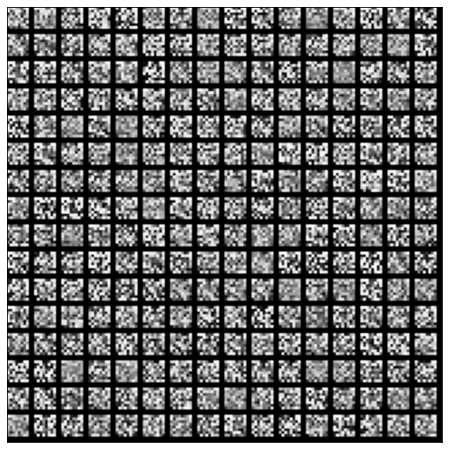

n_learn: 1000
Error_fake: 0.5879642278957011 Acc_fake: 0.6875
Error_real: 0.7431550621690785 Acc_real: 0.5


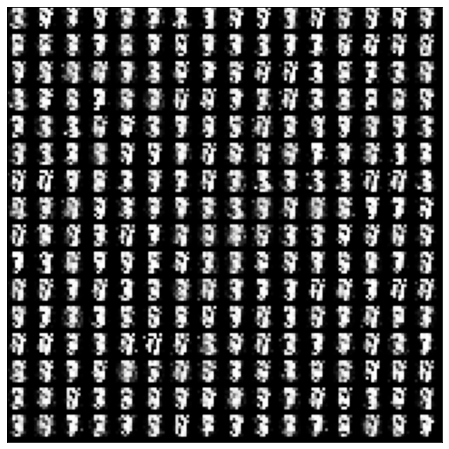

n_learn: 2000
Error_fake: 0.6042579000921702 Acc_fake: 0.875
Error_real: 0.6917713248993187 Acc_real: 0.5625


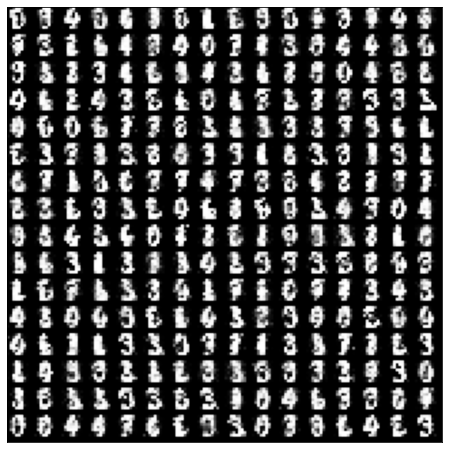

n_learn: 3000
Error_fake: 0.6208271481378036 Acc_fake: 0.875
Error_real: 0.7748914067407721 Acc_real: 0.3125


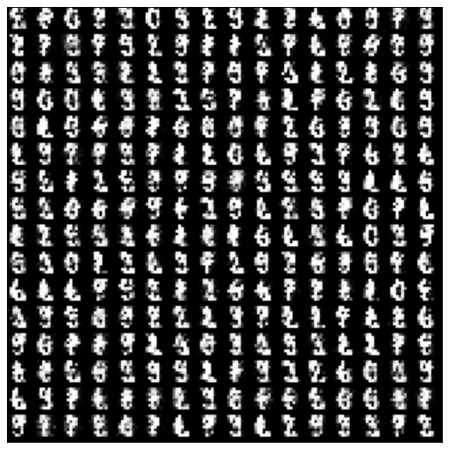

n_learn: 4000
Error_fake: 0.7106612605528553 Acc_fake: 0.4375
Error_real: 0.5448972722608598 Acc_real: 0.8125


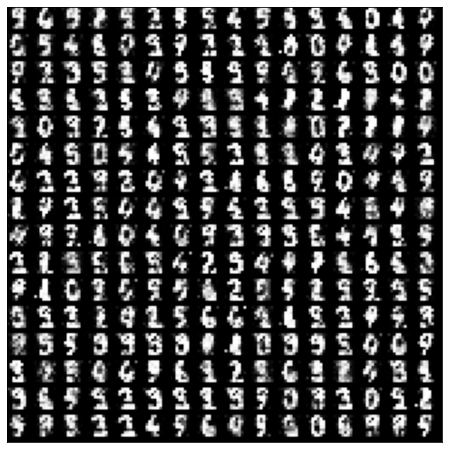

n_learn: 5000
Error_fake: 0.5522046931384259 Acc_fake: 0.875
Error_real: 0.6826978089110252 Acc_real: 0.625


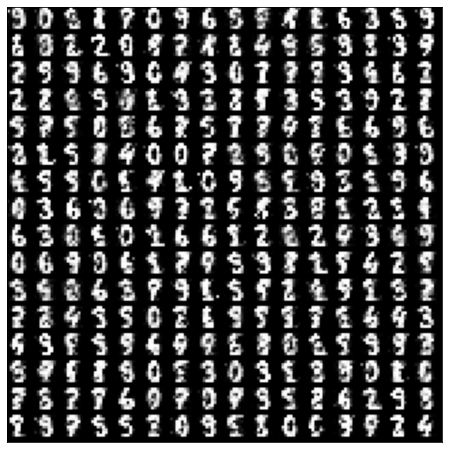

n_learn: 6000
Error_fake: 0.6172916363878601 Acc_fake: 0.6875
Error_real: 0.6307644846055661 Acc_real: 0.625


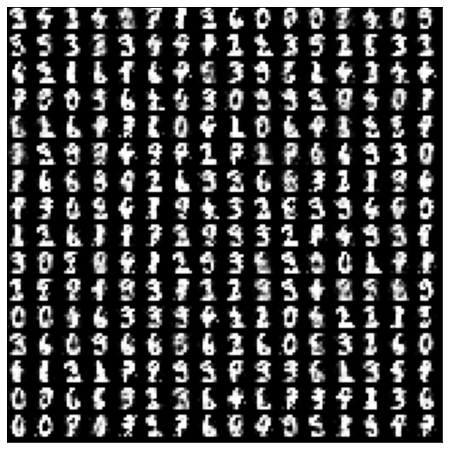

n_learn: 7000
Error_fake: 0.6065028803222381 Acc_fake: 0.625
Error_real: 0.7011739320265926 Acc_real: 0.5


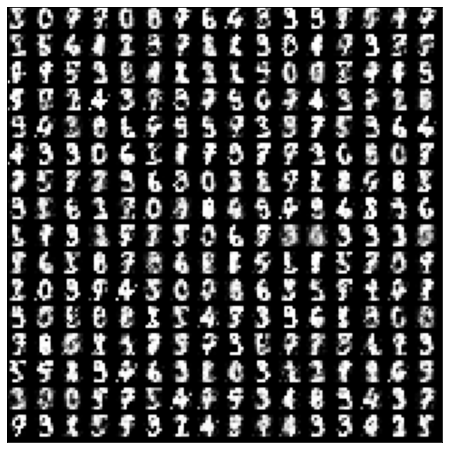

n_learn: 8000
Error_fake: 0.5165933504465328 Acc_fake: 0.8125
Error_real: 0.6121626776714244 Acc_real: 0.625


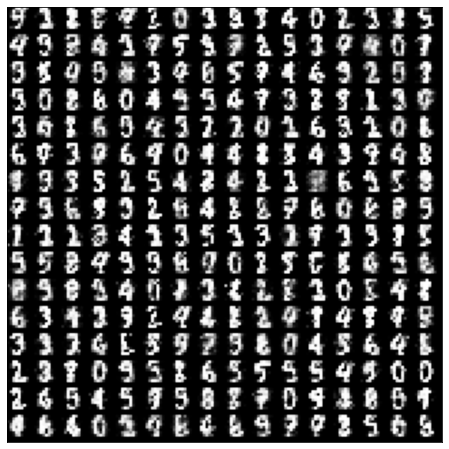

n_learn: 9000
Error_fake: 0.46811196841803315 Acc_fake: 0.8125
Error_real: 0.6602126996015623 Acc_real: 0.5625


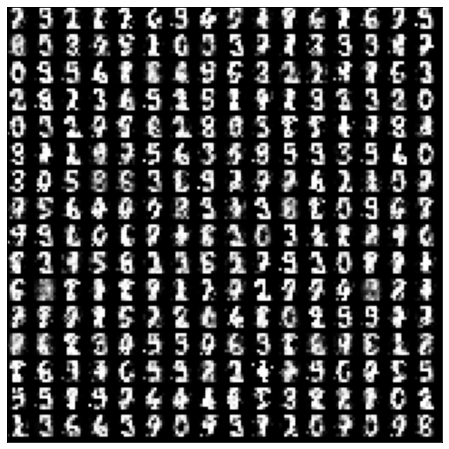

n_learn: 10000
Error_fake: 0.5508183691461763 Acc_fake: 0.6875
Error_real: 0.5222048487160111 Acc_real: 0.625


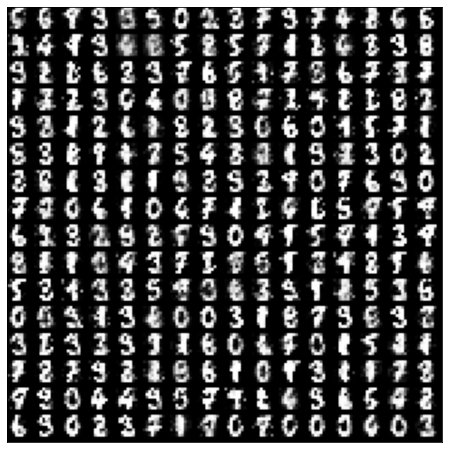

In [6]:
import numpy as np
# import cupy as np
import matplotlib.pyplot as plt
from sklearn import datasets

# -- 각 설정값 --
img_size = 8
n_noise = 16
eta = 0.001
n_learn = 10001
interval = 1000
batch_size = 32

# -- 훈련 데이터 생성 --
digits_data = datasets.load_digits()
x_train = np.asarray(digits_data.data)   # GPU 대응
x_train = x_train / 15*2-1               # 범위는 -1~1
t_train = digits_data.target

# -- 각 전결합 신경망층에서 상속할 입력층 --
class BaseLayer:
    def update(self, eta):
        self.w -= eta * self.grad_w
        self.b -= eta * self.grad_b
        
# -- 은닉층 --
class MiddleLayer(BaseLayer):
    def __init__(self, n_upper, n):
        # He의 초깃값
        self.w = np.random.randn(n_upper, n) * np.sqrt(2/n_upper)
        self.b = np.zeros(n)
        
    def forward(self, x):
        self.x = x
        self.u = np.dot(x, self.w) + self.b
        self.y = np.where(self.u <= 0, 0, self.u)    # ReLU 함수
    
    def backward(self, grad_y):
        delta = grad_y * np.where(self.u <= 0, 0, 1)
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        self.grad_x = np.dot(delta, self.w.T)
        
# -- 생성자의 출력층 --
class GenOutLayer(BaseLayer):
    def __init__(self, n_upper, n):
        # 자비에르 초기화 기반의 초깃값
        self.w = np.random.randn(n_upper, n) / np.sqrt(n_upper)
        self.b = np.zeros(n)
        
    def forward(self, x):
        self.x = x
        u = np.dot(x, self.w) + self.b
        self.y = np.tanh(u)
        
    def backward(self, grad_y):
        delta = grad_y * (1 - self.y**2)
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        self.grad_x = np.dot(delta, self.w.T)
        
# -- 식별자의 출력층 --
class DiscOutLayer(BaseLayer):
    def __init__(self, n_upper, n):
        # 자비에르 초기화 기반의 초깃값
        self.w = np.random.randn(n_upper, n) / np.sqrt(n_upper)
        self.b = np.zeros(n)
        
    def forward(self, x):
        self.x = x
        u = np.dot(x, self.w) + self.b
        self.y = 1/(1+np.exp(-u))  # 시그모이드 함수
        
    def backward(self, t):
        delta = self.y - t
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        self.grad_x = np.dot(delta, self.w.T)
        
# -- 생성자와 식별자의 초기화 --
gen_layers = [MiddleLayer(n_noise, 32),
              MiddleLayer(32, 64),
              GenOutLayer(64, img_size*img_size)]

disc_layers = [MiddleLayer(img_size*img_size, 64),
               MiddleLayer(64, 32),
               DiscOutLayer(32, 1)]

# -- 순전파 함수 --
def forward_propagation(x, layers):
    for layer in layers:
        layer.forward(x)
        x = layer.y
    return x

# -- 역전파 함수 --
def backpropagation(t, layers):
    grad_y = t
    for layer in reversed(layers):
        layer.backward(grad_y)
        grad_y = layer.grad_x
    return grad_y

# -- 파라미터 갱신 함수 --
def update_params(layers):
    for layer in layers:
        layer.update(eta)
        
# -- 오차 계산 함수 --
def get_error(y, t):
    eps = 1e-7
    
    # 두 값의 교차 엔트로피 오차를 반환
    return -np.sum(t*np.log(y+eps) + (1-t)*np.log(1-y+eps)) / len(y)

# -- 정확도 계산 --
def get_accuracy(y, t):
    correct = np.sum(np.where(y<0.5, 0, 1) == t)
    return correct / len(y)

# -- 모델 훈련 --
def train_model(x, t, prop_layers, update_layers):
    y = forward_propagation(x, prop_layers)
    backpropagation(t, prop_layers)
    update_params(update_layers)
    return (get_error(y, t), get_accuracy(y, t))

# -- 이미지를 생성하고 나타냄 --
def generate_images(i):
    # 이미지 생성
    n_rows = 16  # 행 수
    n_cols = 16  # 열 수
    noise = np.random.normal(0, 1, (n_rows*n_cols, n_noise))
    g_imgs = forward_propagation(noise, gen_layers)
    g_imgs = g_imgs/2 + 0.5   # 범위는 0~1
    
    img_size_spaced = img_size + 2
    
    # 이미지 전체
    matrix_image = np.zeros((img_size_spaced*n_rows, img_size_spaced*n_cols))
    
    # 생성된 이미지를 나열해 1장의 이미지로 만듦
    for r in range(n_rows):
        for c in range(n_cols):
            g_img = g_imgs[r*n_cols + c].reshape(img_size, img_size)
            top = r*img_size_spaced
            left = c*img_size_spaced
            matrix_image[top : top+img_size, left : left+img_size] = g_img
            
    plt.figure(figsize=(8, 8))
    plt.imshow(matrix_image.tolist(), cmap="Greys_r")
    
    # 축 눈금의 레이블과 선을 삭제
    plt.tick_params(labelbottom=False, labelleft=False,
                   bottom=False, left=False)
    plt.show()
    
# -- GAN 학습 --
batch_half = batch_size // 2
error_record = np.zeros((n_learn, 2))
acc_record = np.zeros((n_learn, 2))

for i in range(n_learn):
    # 노이즈에서 이미지를 생성하여 식별자를 훈련시킴
    noise = np.random.normal(0, 1, (batch_half, n_noise))
    imgs_fake = forward_propagation(noise, gen_layers)  # 이미지 생성
    t = np.zeros((batch_half, 1))  # 정답은 0
    error, accuracy = train_model(imgs_fake, t, disc_layers, disc_layers)
    error_record[i][0] = error
    acc_record[i][0] = accuracy
    
    # 실제 이미지를 사용하여 식별자를 훈련시킴
    rand_ids = np.random.randint(len(x_train), size=batch_half)
    imgs_real = x_train[rand_ids, :]
    t = np.ones((batch_half, 1))   # 정답은 1
    error, accuracy = train_model(imgs_real, t, disc_layers, disc_layers)
    error_record[i][1] = error
    acc_record[i][1] = accuracy
    
    # 생성자와 식별자 모델을 결합해 생성자만 훈련시킴
    noise = np.random.normal(0, 1, (batch_size, n_noise))
    t = np.ones((batch_size, 1))  # 정답은 1
    train_model(noise, t, gen_layers+disc_layers, gen_layers)
    
    # 일정한 간격으로 오차와 생성된 이미지를 나타냄
    if i % interval == 0:
        print("n_learn:", i)
        print("Error_fake:", error_record[i][0], "Acc_fake:", acc_record[i][0])
        print("Error_real:", error_record[i][1], "Acc_real:", acc_record[i][1])
        generate_images(i)

    오차와 정확도 추이

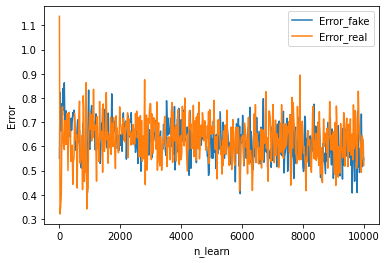

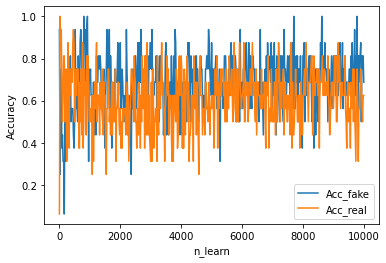

In [7]:
step = 20

# -- 오차의 추이 --
axis_x = range(1, n_learn+1, step)
axis_y = error_record[::step, :]  # step 단위로 추출
plt.plot(axis_x, axis_y[:, 0].tolist(), label="Error_fake")
plt.plot(axis_x, axis_y[:, 1].tolist(), label="Error_real")
plt.legend()
plt.xlabel("n_learn")
plt.ylabel("Error")
plt.show()

# -- 정확도 추이 --
axis_x = range(1, n_learn+1, step)
axis_y = acc_record[::step, :]
plt.plot(axis_x, axis_y[:, 0].tolist(), label="Acc_fake")
plt.plot(axis_x, axis_y[:, 1].tolist(), label="Acc_real")
plt.legend()
plt.xlabel("n_learn")
plt.ylabel("Accuracy")
plt.show()